In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import os
import csv
import pandas as pd
from PIL import Image
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import display
from fastai.callbacks import *
import json

In [23]:
# data without augmentation
# images which were too rectangular was removed
path = Path('clear_data')
np.random.seed(42)
# create data bunch for different sizes
data_dict = {} 
sizes = [32 * i for i in range(1,12)]
for size in sizes:
    data = ImageDataBunch.from_folder(path, train="train", valid = "valid", bs = 32, 
           ds_tfms=get_transforms(), size=size, num_workers=0).normalize(imagenet_stats)
    data_dict[size] = data

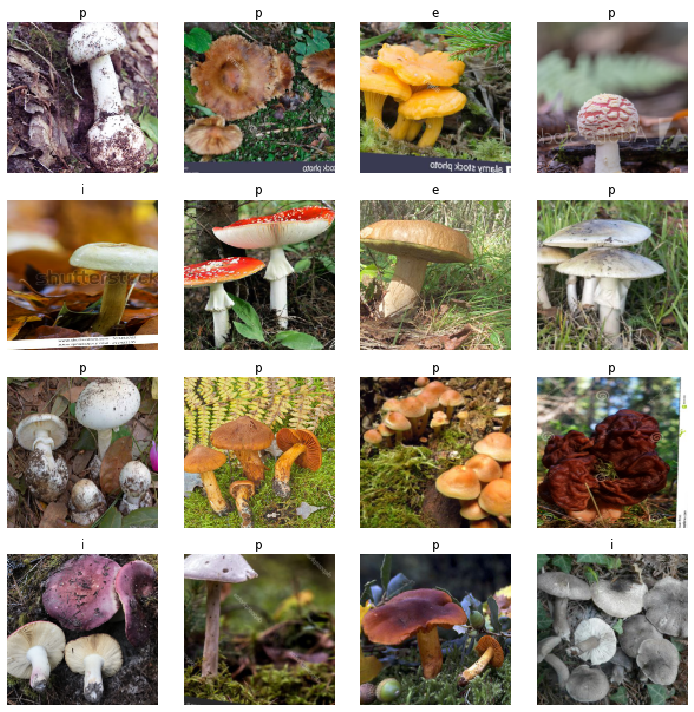

In [20]:
# draw some images, e = edible, i = inedible, p = poisonous mushrooms
data_dict[128].show_batch(rows=4, figsize=(10,10))

In [5]:
#create dictionary of learners, using resnet18 and callback func.
# to_fp16 for speed
learners_dict = {size : cnn_learner(data_dict[size], models.resnet18, metrics=accuracy,
                                    callback_fns=[CSVLogger], wd=0.1).to_fp16()
                 for size in sizes}

In [ ]:
#First step of training can be finding the best learning rate. The best learning rate has 
plt_lst = []
for size in sizes:
    learner_temp = learners_dict[size]
    learner_temp.unfreeze()
    learner_temp.lr_find(wd=0.1)    
    pt = learner_temp.recorder.plot(return_fig=True)
    ax = pt.gca()
    ax.set_title(f"Image size = {size}x{size}")
    plt_lst.append(pt)

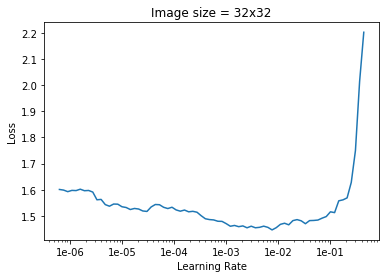

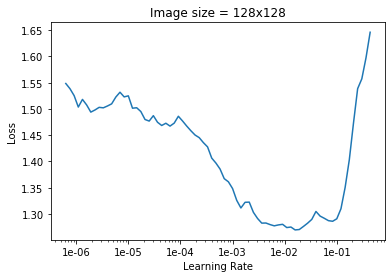

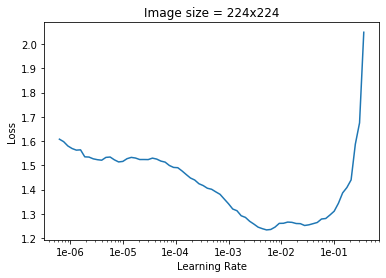

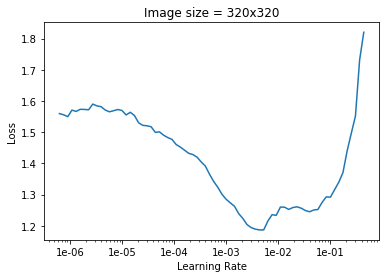

In [7]:
for lr_plot in plt_lst[::3]:
    display(lr_plot)

In [ ]:
# train a bit, appling 4 cycles
# max_lr = 4e-4 is a good choice
dfs = {}
for size in sizes:
    learner_temp = learners_dict[size]
    print(f"image size = {size} x {size} pixels")
    learner_temp.fit_one_cycle(4, max_lr = 4e-4)
    dfs[size] = learner_temp.csv_logger.read_logged_file()

In [8]:
def save_json(data, name):
    with open(name, 'w') as outfile:
        json.dump(data, outfile)

def load_json(name):
    with open(name, 'r') as infile:
        data = json.load(infile)
    return data

In [9]:
# save data as json file and load after
#stats_18 = {size : data.values.tolist() for size, data in dfs.items()}
#save_json(stats_18, 'size_stats.json')
re_stat_18 = load_json('size_stats.json')
#remove time column
no_time = {size:np.array(val)[:,:-1].astype(float) for size, val in re_stat_18.items()}
acc = {int(size) : np.max(a[:,-1]) for size, a in no_time.items()}

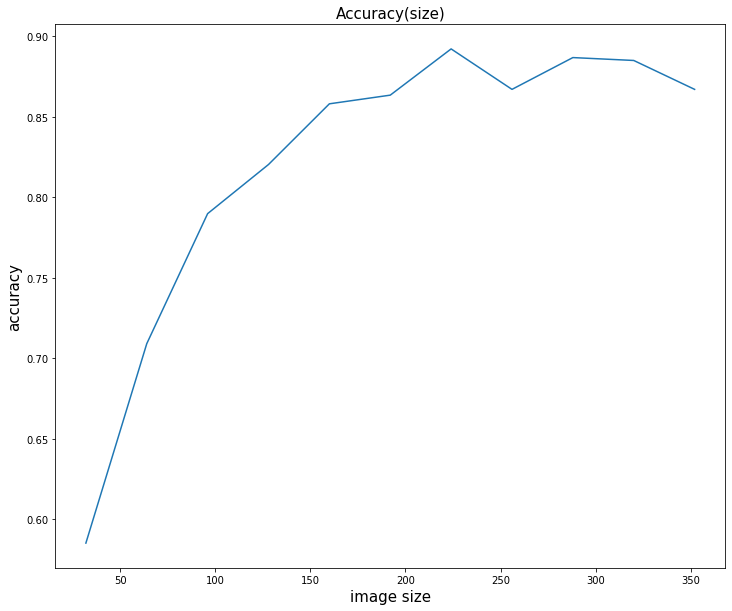

In [10]:
plt.rcParams["figure.figsize"] = (12,10)
plt.plot(*zip(*sorted(acc.items())))
plt.xlabel('image size', size = 15)
plt.ylabel('accuracy', size = 15)
plt.title('Accuracy(size)', size = 15);

In [22]:
# for size 224 we get the best accuracy
# I reduced bs to 32 to could use resnet50
path = Path('clear_data')
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="train", valid = "valid", bs = 32, 
           ds_tfms=get_transforms(), size=224, num_workers=0).normalize(imagenet_stats)

In [ ]:
# train using different models
dfs = {}
for model, n in zip([models.resnet18, models.resnet34, models.resnet50],
                    [18,34,50]):
    L = cnn_learner(data, model, metrics=accuracy, callback_fns=[CSVLogger]).to_fp16()   
    L.unfreeze()
    L.lr_find() 
    L.recorder.plot() 
    sugg_lr = 4e-04
    L.fit_one_cycle(4, max_lr = sugg_lr)
                                  
    L.fit_one_cycle(2, max_lr = slice(1e-6, 1e-4))
    dfs[n] = L.csv_logger.read_logged_file().values.tolist()

In [11]:
df = load_json('three_models.json')

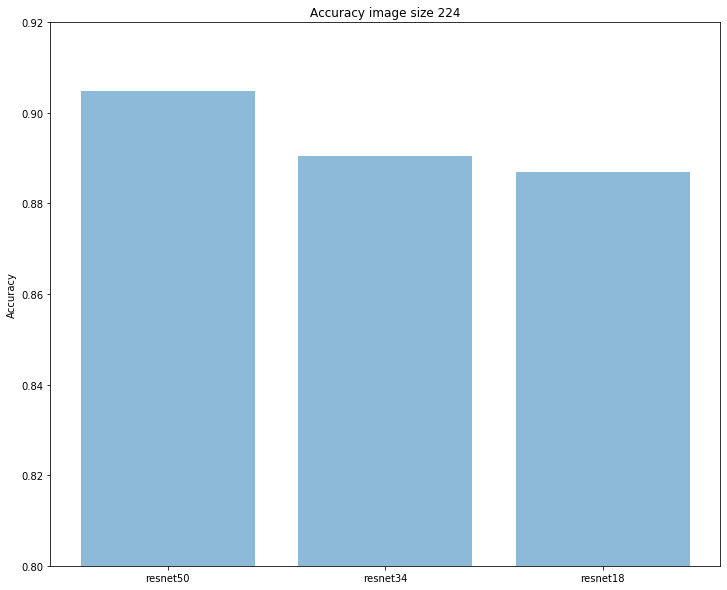

In [12]:
D = []
for k, v in df.items():
    temp = np.max(np.array(v)[:,3].astype(np.float))
    D.append(temp)

objects = ('resnet50', 'resnet34', 'resnet18')
y_pos = np.arange(len(objects))
plt.bar(y_pos, D, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.ylim((0.8, 0.92))
plt.title('Accuracy image size 224');

In [ ]:
#Remove 1% images from training data set with the highest loss.
'''
_, ind, losses = L.get_preds(data.train_ds,with_loss=True)
out = len(data.train_ds)//100
args = np.argpartition(losses, -out)[-out:]
data.train_ds.items[args] # fancy indexing
dest = Path('data/removed')
for el in args:
    name = str(data.train_ds.items[el]).split('\\')[-1]  
    os.rename(data.train_ds.items[el], dest/name)
'''

In [39]:
def save_trfs(one_to_n, **kwargs): 
    '''
    Creates for every image one_to_n transformed copies.
    '''
    def get_ex(path): return open_image(path)
    for folder in ('e', 'i', 'p'):
        path = Path()/'clear_data/train'/folder
        des = Path()/'data/train'/folder
        for img_name in os.listdir(path):
            img_path = path/img_name
            for i in range(one_to_n):
                channel = random.choice([0,1,2])
                thresh = random.choice([0.1,0.2,0.4])
                light = random.choice([0.3,0.5,0.7])
                sq = random.choice(np.linspace(0.66,1.33,5))
                holes = random.choice([1,2,4,8])
                tfms = [rotate(degrees=30, p=0.5),
                        *zoom_crop(scale=(0.75,1.5), do_rand=True),
                        symmetric_warp(magnitude=(-0.2,0.2)),
                        brightness(change=light), flip_lr(),
                       contrast(scale = (0.5,1.5)),
                       squish(scale = sq),
                       cutout(n_holes = (1,10), length = (1,50))]

                img = get_ex(path/img_name).apply_tfms(tfms, **kwargs)
      
                img.save(f"{des/(img_name[:-4]+'_'+str(i))}.jpg")

#save_trfs(10, size=334, padding_mode='zeros')

In [14]:
path = Path('data')
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="train", valid = "valid", bs = 48, 
           ds_tfms=get_transforms(), size=334, num_workers=4).normalize(imagenet_stats)

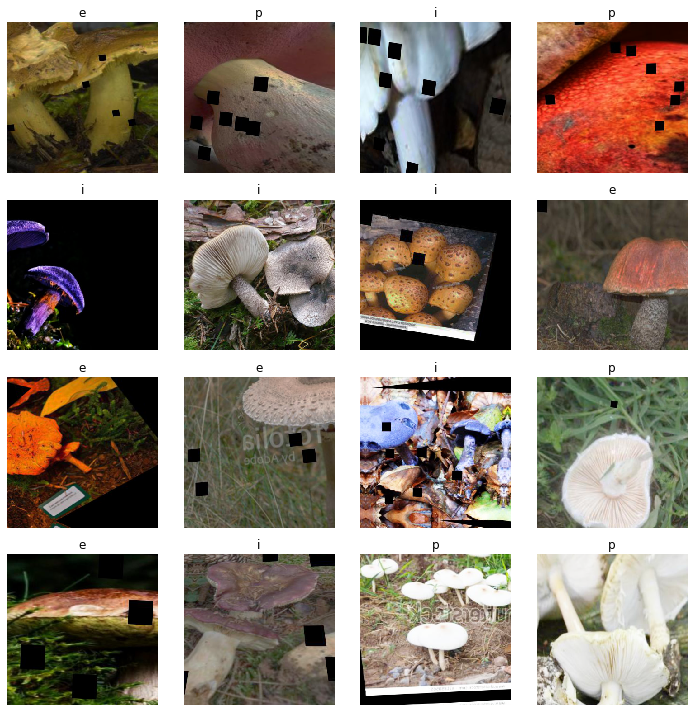

In [15]:
data.show_batch(rows=4, figsize=(10,10))

In [16]:
L = cnn_learner(data, models.resnet34, metrics=accuracy, callback_fns=[CSVLogger]).to_fp16()

In [17]:
#L.load('best2'); 

In [11]:
L.fit_one_cycle(2, max_lr = slice(1e-7,1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.023309,0.197133,0.944345,07:54
1,0.027772,0.187735,0.949731,07:26


In [8]:
L.fit_one_cycle(2, max_lr = slice(1e-7,1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.034746,0.140768,0.957182,07:18
1,0.041834,0.145109,0.955801,07:05


In [18]:
L.load('best_end');

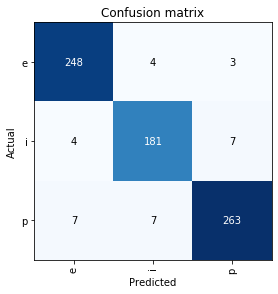

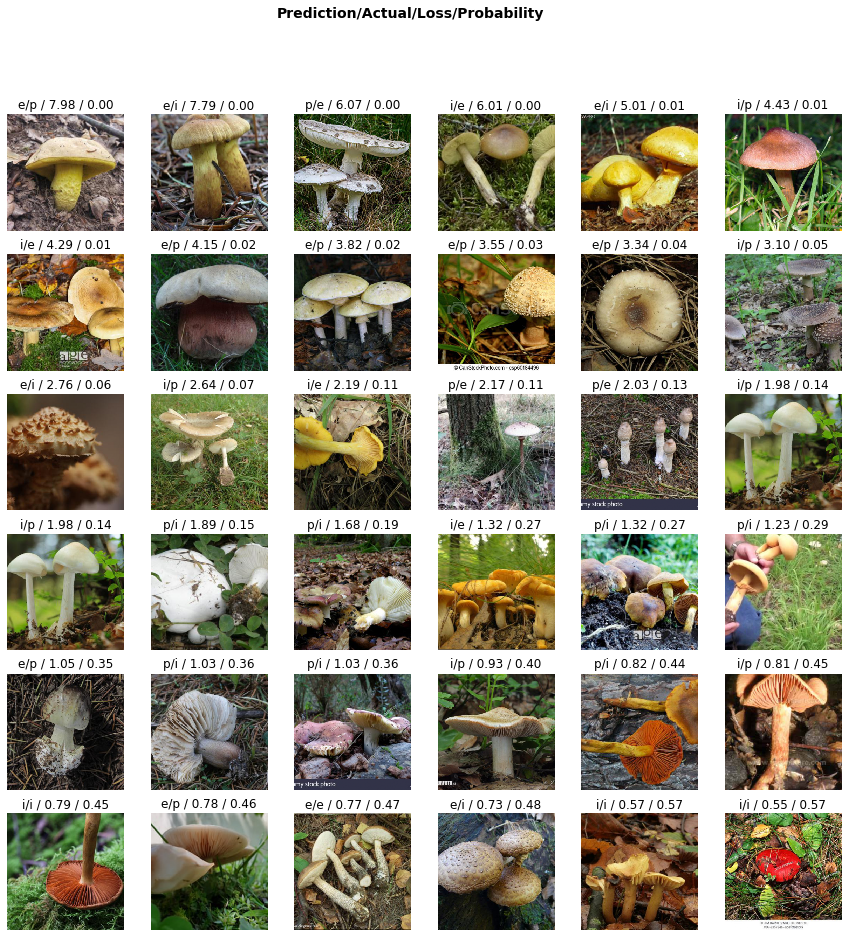

In [45]:
interp = ClassificationInterpretation.from_learner(L)
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5)
interp.plot_top_losses(36, figsize=(15,15))
# Data augmentation and big image size 334 give us the accuracy above 95%

In [51]:
# remove only from train data set
path = Path('data/train')
from fastai.widgets import *

db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=334)
                   .databunch()
     )

In [54]:
ds, idxs = DatasetFormatter().from_toplosses(L, n_imgs = 200)

In [55]:
# Filter data with high loss, change labels if image is misclassified
ImageCleaner(ds, idxs, path) # creates cleaned.csv file, I renamed it to cleaned_loss.csv

'No images to show :)'

In [58]:
path = Path('data')
db = (ImageList.from_csv(path, csv_name='cleaned_loss.csv')
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=334)
                   .databunch()
)
L_clr = cnn_learner(db, models.resnet34, metrics=accuracy, callback_fns=[CSVLogger])
L_clr.load('best_end');

In [63]:
ds, idxs = DatasetFormatter().from_similars(L_clr, n_imgs=200)

Getting activations...


Computing similarities...


In [ ]:
# Remove similar images
ImageCleaner(ds, idxs, path, duplicates=True)

In [7]:
# Create DataFrame what contains info about train and valid data set
import pandas as pd
train = pd.read_csv('data/cleaned.csv')
# add boolean valid column
train['valid'] = False

In [62]:
valid = pd.DataFrame(columns=['name','label','valid'])
path = Path('data/valid')
for folder in os.listdir(path):
    for file in os.listdir(path/folder):
        name = '\\'.join(str(path/folder/file).split('\\')[1:])
        valid = valid.append({'name':name, 'label':folder, 'valid':True}, ignore_index=True)

In [50]:
all_data = pd.concat([valid, train])

In [61]:
# Data after cleaning are ready to reuse
data = (ImageList.from_df(all_data, 'data')
.split_from_df(col='valid')
.label_from_df()
.transform(get_transforms(), size = 334)
.databunch()
.normalize(imagenet_stats))